# Image processing with OpenCV
## Margin Removal
***Objective:*** *to crop the (black) background from page images, only leaving the minimum margin outside the main image of
the page itself. Also produces a binary (1-bit) image suitable for feeding into an OCR/HTR pipeline.
The algorithm as it stands does need a fairly dark, even background (e.g. the grey copy stand with grid causes problems).*
#### Import numpy, scikit-image and open computer vision libraries
* **numpy** (*) provides the matrix arithmetic (not currently used)
* **cv2** (opencv-python) provides the image processing functions
* **skimage** (scikit-image) provides the embedded image display in Jupyter
* **matplotlib** (*) is used to lay out side-by-side comparisons (not currently used)
* **copy** is needed to perform deep copies of the images (alternatives?)

These packages (*) will need to be installed in the virtual instance or globally if running from Jupyter itself. You may
also need to install Qt packages for the interactive image display.

In [136]:
from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv
from skimage import io
import copy

#### Configuration
* Set **SHOW_FULLSIZE** = True to show full sized images
* **DELAY** is the duration to show the full sized images in milliseconds

In [137]:
SHOW_FULLSIZE = False
DELAY = 2000                # in milliseconds
INPUT_PATH = '../data/'
OUTPUT_PATH = '../output/'
OUTPUT_THRESHOLD = 64       # Threshold for final output
CROPPING_THRESHOLD = 1      # Threshold used to select the crop outline

fname = 'uoedh_culver house letters12659'

### Helper functions

* **makethumb()** is a quick rescaling function, reducing an image to 10% linear size
* **showbriefly()** shows an image for DELAY milliseconds or until a key is pressed
* **showimage()** is a combined embedded and popup display

In [138]:
def showimage(i):
    io.imshow(makethumb(i))
    showbriefly(i)

def makethumb(i):
    return cv.resize(i,None,fx=0.1,fy=0.1,interpolation=cv.INTER_CUBIC)

def showbriefly(i):
    if SHOW_FULLSIZE:
        v = cv.imshow('Image',i)
        cv.waitKey(DELAY)
        cv.destroyWindow(v)

### Load the image
* Image is read as a BGR matrix

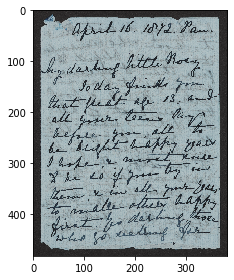

In [139]:
img = cv.imread(filename=INPUT_PATH+fname+'.jpg')
showimage(img)

#### Convert to grayscale

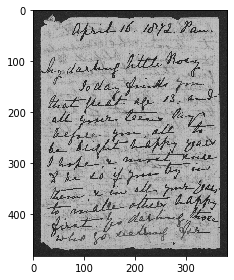

In [140]:
grey = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
showimage(grey)

### Use cv.threshold() to isolate writing
* note that **cv.threshold()** returns two arguments:
 * **ret** the threshold mask pattern (temporary variable)
 * **thresh** the image with threshold applied
 * Uses the adaptive **OTSU** algorithms for better results on uneven exposures

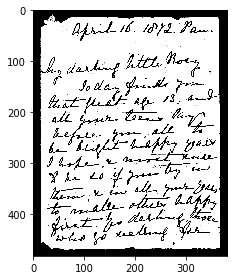

In [141]:
ret,thresh = cv.threshold(grey,OUTPUT_THRESHOLD,255,cv.THRESH_OTSU)
showimage(thresh)

#### Find the Contours
* Redo the threshold with more extreme settings
* Find the contours of the objects in the image


From: https://stackoverflow.com/questions/13538748/crop-black-edges-with-opencv

In [142]:
_, cropthresh = cv.threshold(thresh,CROPPING_THRESHOLD,255,cv.THRESH_BINARY)

contours,hierarchy = cv.findContours(cropthresh,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)

#### Find contour with maximal area (largest item on page)
* Step through each of the contours[] keeping track of the contour giving the maximal value
* Store the max contour in **cont**
* *might be a better way of doing this*

In [143]:
maxc = []
maxa = 0
for c in contours:
    a = cv.contourArea(c)
    if a>maxa:
        maxc=c
        maxa=a
        print('new maximum: '+str(maxa))
cont = maxc

new maximum: 2.5
new maximum: 3.5
new maximum: 9.5
new maximum: 22.5
new maximum: 15894224.0


#### Contour results:


In [144]:
print(cont)

#print(hierarchy)

[[[383  84]]

 [[382  85]]

 [[383  86]]

 ...

 [[386  86]]

 [[385  85]]

 [[384  85]]]


#### Find the bounding rectangle of that maximal contour

In [145]:
x,y,w,h = cv.boundingRect(cont)

print('x,y,x`,y` = ',x,y,x+w,y+h)
print('w,h = ',w,h)

x,y,x`,y` =  143 84 3672 4724
w,h =  3529 4640


#### Show the bounding box in green for confirmation
* Note that the **rectangle()** function modifies the image it references
 * Hence the need to do a **deepcopy()**

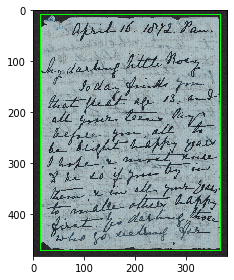

In [146]:
boundbox = copy.deepcopy(img)
cv.rectangle(boundbox,(x,y),(x+w,y+h),(0,255,0),20)
showimage(boundbox)

#### Crop the original image using numpy matrix slicing

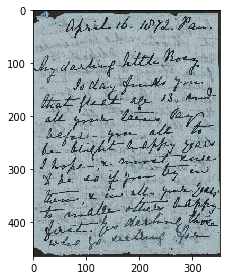

In [147]:
crop = img[y:y+h,x:x+w]
showimage(crop)

#### And now thresholded image

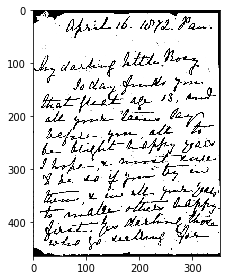

In [148]:
cropocr = thresh[y:y+h,x:x+w]
showimage(cropocr)

#### Write the output images

In [149]:
print('Writing cropped colour image')
_ = cv.imwrite(img=crop,filename=OUTPUT_PATH+fname+'-cropped.jpg')
print('Writing cropped thresholded image for OCR processing')
_ = cv.imwrite(img=cropocr, filename=OUTPUT_PATH+fname+'-thresholded.jpg')

Writing cropped colour image
Writing cropped thresholded image for OCR processing


#### Remove any stray image windows

In [150]:
cv.destroyAllWindows()